# Impedance control of a 6 dof manipulator

## Import all the modules needed for the simulation

In [13]:
from pickle import GLOBAL
from mpl_toolkits import mplot3d
import pinocchio as pin
import numpy as np
import sys
import os
from pinocchio.visualize import MeshcatVisualizer
import time
import math
import matplotlib.pyplot as plt
from numpy.linalg import norm, solve, inv, svd, det
from scipy.spatial.transform import Rotation
import meshcat.geometry as g
import meshcat.transformations as tf
plt.rcParams['text.usetex'] = True
%matplotlib notebook

## Bring the URDF model of the robot 

In [14]:
pinocchio_model_dir = '/home/unknown/Documents/Posdoc/ModelsCads/urdf' 
mesh_dir = pinocchio_model_dir + '/kinova_description/meshes/'
urdf_model_path =pinocchio_model_dir + '/j2s6s200_simple.urdf'
model, collision_model, visual_model = pin.buildModelsFromUrdf(urdf_model_path, mesh_dir)
# Choose of the visualizer
viz = MeshcatVisualizer(model, collision_model, visual_model)

## Identify the frame and joint IDs

In [15]:
frameIndex = model.getFrameId('j2s6s200_end_effector')
jointIndex = model.frames[frameIndex].parent
# Create data required by the algorithms
data     = model.createData()

# Function to plot matrices in matlab way

In [16]:
def mprint(M, name="ans",eps=1e-15):
    '''
    Matlab-style pretty matrix print.
    '''
    if isinstance(M, pin.SE3):
        M = M.homogeneous
    if len(M.shape) == 1:
        M = np.expand_dims(M, axis=0)
    ncol = M.shape[1]
    NC = 6
    print(name, " = ")
    print()

    Mmin = lambda M: M.min()
    Mmax = lambda M: M.max()
    Mm = Mmin(abs(M[np.nonzero(M)]))
    MM = Mmax(abs(M[np.nonzero(M)]))

    fmt = "% 10.4f" if Mm < 1e-5 or MM > 1e6 or MM / Mm > 1e3 else "% 1.5f"
    for i in range(math.floor((ncol - 1) / NC + 1)):
        cmin = i * 6
        cmax = (i + 1) * 6
        cmax = ncol if ncol < cmax else cmax
        print("Columns %s through %s" % (cmin, cmax - 1))
        print()
        for r in range(M.shape[0]):
            sys.stdout.write("  ")
            for c in range(cmin, cmax):
                if abs(M[r,c])>eps: sys.stdout.write(fmt % M[r,c]  + "   ")
                else: sys.stdout.write(" 0"+" "*9)
            print()
        print()

## Initialize the viewer

In [17]:
try:
    viz.initViewer()
except ImportError as err:
    print("Error while initializing the viewer. It seems you should install gepetto-viewer")
    print(err)
    sys.exit(0)

try:
    viz.loadViewerModel("pinocchio")
except AttributeError as err:
    print("Error while loading the viewer model. It seems you should start gepetto-viewer")
    print(err)
    sys.exit(0)
viz.viewer['world'].set_transform(np.array(pin.XYZQUATToSE3([0, 0, 0, 0, 0, 1, 0])))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [18]:
def meshcat_material(r, g, b, a):
    import meshcat

    material = meshcat.geometry.MeshPhongMaterial()
    material.color = int(r * 255) * 256 ** 2 + int(g * 255) * 256 + int(b * 255)
    material.opacity = a
    return material

# Simulation


## Manipulator dynamic model

\begin{equation}
\mathbf{
M(q)\ddot{q} + C(q,\dot{q})\dot{q} + g(q) = \tau + J(q)^T F_{ext}}
\label{eq:01}
\end{equation}

### Desired interaction model 

\begin{equation}
\mathbf{
M_d(t)\ddot{x} + D_d(t)\dot{x} = \hat{F}_e}
\label{eq:13}
\end{equation}

### The variable parameter $M_d(t), D_d(t)$ are given as follows

A low mass is always desirable both, in acceleration (human force pointing towards the goal) and decelartion (human force pointing opposite of the goal). This desired mass can be expressed with an ellipsoid of the form
\begin{equation}
\mathbf{A_m} = \mathbf{Q_m} \mathbf{\Lambda_m} \mathbf{Q_m}^T
\end{equation}

where $\mathbf{Q_m} = [v_1|v_2|v_3]$ and $\mathbf{\Lambda_m} = diag(\lambda_1, \lambda_2, \lambda_3)$. Here, the eigenvector $v_1$ is chosen acording to the desired goal as 

\begin{equation}
v_1 = \frac{\mathbf{P_G} - \mathbf{P_e}}{||{\mathbf{P_G - P_e}}||}
\end{equation}

where $P_G$ and $P_e$ are the desired and current pose of the end-effector, respectively. The rest of the eigenvectors are freely selected to complete a right-handed orthonormal frame. In this work are chosen as
\begin{equation}
v_2 = \frac{\hat{z} \times v_1}{||{\hat{z} \times v_1}||}, ~~~~ v_3 = v_1 \times v_2.
\end{equation}

The eigenvalues of $\Lambda_m$ are the reciprocals of the squares of the semi-axes length. Thus
\begin{equation}
\lambda_1 = \frac{1}{d_{min}^2}, ~~ \lambda_2 = \frac{1}{d_{max}^2}, ~~ \lambda_3 = \frac{1}{d_{max}^2} 
\end{equation}
The current value of the desired mass $d_m$ can be computed as the distance from the centre of the ellipsoid to one of the two points found as the intersection of this shape with a straight line directed as the human force vector $\mathbf{f} = [f_x,f_y,f_z]^T$
\begin{equation}
d_m = \frac{1}{\sqrt{\mathbf{u_f}^T \mathbf{A_m} \mathbf{u_f} }}.
\end{equation}

A low damping is advisable when the human is pushing towards the target while a high damping is convenient when the operator is pulling the robot in order to brake it in proximity of the goal position. A possible apporach is to combine two half-ellipsoids. The first half is described as for the case of the mass while the second one is characterized by the same principal axes directions and the only difference is the length of the first semi-axis $\lambda_1$ that is chosen greater than or equal of the maximum value. Thus, the eigenvalues of the second half-ellipsoid can be described by

\begin{equation}
\Lambda_d = \begin{bmatrix}
{\lambda_1}&{0}&{0}\\
{0}&{\lambda_2}&{0}\\
{0}&{0}&{\lambda_3}
\end{bmatrix}, ~~ \lambda_1 = \frac{1}{d_{max}^2}, ~~ \lambda_2 = \frac{1}{\bar{d}^2}, ~~ \lambda_3 = \frac{1}{\bar{d}^2}
\end{equation}

where $\bar{d}$ is an intermediate value. This value can be also applied for the first half-ellipsoid. Once the eigenvectors of $\mathbf{Q_d}$ are given for both half-ellipsoids, then, $A_d$ can be computed as
\begin{equation}
\mathbf{A_d} = \mathbf{Q_d} \mathbf{\Lambda_d} \mathbf{Q_d}^T
\end{equation}

Finally as the proper half-ellipsoid are chosen according to the sign of the scalar product $\mathbf{f}\cdot \mathbf{v_1}$, the current value of $d_d$ can be obtained as follows

\begin{equation}
    d_d=
    \begin{cases}
       \frac{1}{\sqrt{\mathbf{u_f}^T \mathbf{A_{d_1}} \mathbf{u_f} }}, &  \mathbf{f}\cdot \mathbf{v_1} > 0 \\
      \frac{1}{\sqrt{\mathbf{u_f}^T \mathbf{A_{d_2}} \mathbf{u_f} }}, &  \mathbf{f}\cdot \mathbf{v_1} < 0 
    \end{cases}
\end{equation}

where $\mathbf{A_{d_1}}$ and $\mathbf{A_{d_2}}$ correspond to the first and second half-ellipsoids respectively.


### The closed loop control law $\tau$ can be written 

\begin{equation}
\mathbf{\tau} = -\mathbf{J^T} \mathbf{\Lambda}[\mathbf{\dot{J}}\mathbf{\dot{q}} + \mathbf{M_d(t)^{-1}}(\mathbf{D_d(t)}\mathbf{\dot{\tilde{x}}} - \mathbf{\hat{F}_{ext}})] +  \mathbf{g(q)} + \mathbf{C(q,\dot{q})}
\end{equation}
where
\begin{equation}
 \mathbf{\Lambda} =  (\mathbf{JM^{-1}J^T)^{-1}}
\end{equation}

## Run simulation 

In [59]:
def run_robot():
    
#     # For "arrow"
#     colors = [0xFF0000, 0x00FF00, 0x0000FF]
#     length = 0.3
#     thickness = 0.005
#     opacity = 1.0
    
#     material = g.MeshLambertMaterial(
#         color=colors, opacity=opacity)
#     cylinder = g.Cylinder(length, thickness)
    
    # Sample a random configuration
    q =np.array([0, 2.9, 1.3, -2.07, 1.4,0]) # Natural position as in the real case
    qdot = pin.utils.zero(model.nv) # this is the angular velocity
    a = pin.utils.zero(model.nv) # angular acceleration

    pin.forwardKinematics(model,data,q)
    pin.updateFramePlacements(model,data) #Computes the placement of all the joints
    OM_act=data.oMf[model.getFrameId("j2s6s200_end_effector")]
    oMdes = pin.SE3(OM_act.rotation,np.array([-0.3643, 0.21839, 0.5414]))# This is the pose of the end-effector refered in the frame of the base

    ## External forces
    fx = 2; fy=0; fz=0; nx =0; ny=0; nz=0
    fext = []

    wrench = np.array([fx,fy,fz,nx,ny,nz])
    wrench_ = pin.Force.Zero()
    wrench_.linear = np.array([fx,fy,fz])
    wrench_.angular = np.array([nx,ny,nz])

    for k in range(model.njoints):
        faux = pin.Force.Zero()
        if k == (model.njoints-1):
            faux.linear = wrench_.linear
            faux.angular =wrench_.angular
        fext.append(faux)

    k1 =0; k2 =0;  k3 =0; k4 =0; k5 =0;  k6 =0
    kps = np.array([k1, k2, k3, k4, k5, k6])
    Kp = np.diag(kps)

    d1 =50; d2 =50;  d3 =50; d4 =0.85; d5 =0.85;  d6 =0.85
    ds = np.array([d1, d2, d3, d4, d5, d6])
    Dd = np.diag(ds) #  Damper Matrix

    md1 =10; md2 =10;  md3 =10; md4 =0.21; md5 =0.21;  md6 =0.21
    mds = np.array([md1, md2, md3, md4, md5, md6])
    Md = np.diag(mds) # Mass Matrix

    # for runing the simulation
    t = 0
    dt = 5e-2
    T = 10
    N = math.floor(T/dt) 
    # for graphs
    t_list = []
    u_list = []
    q_list = [] #q
    pose_list = []
    pose_des_list = [] 
    d_r_list = [] 
    radii_list = []
    rotation_list = []
    # for goal dirven
    d_min = 15
    d_barra =150
    d_max =400 
   
    viz.viewer['world/ball'].set_object(g.Sphere(0.03),
                                    meshcat_material(*[0.1, 0.1,1, .5]))
    viz.viewer['world/ball'].set_transform(tf.translation_matrix([oMdes.translation[0]*-1, 
                                                                  oMdes.translation[1]*-1, oMdes.translation[2]]))
    
    ## for runing the simulation
    for k in range(N):
        t += dt
        tic = time.time()

        pin.forwardKinematics(model,data,q)
        pin.updateFramePlacements(model,data)
        OM_act = data.oMf[frameIndex] # This is the pose of the end-effector refered in the frame of the base
                
        # Construction of goal driven        
        ## First half-ellipsoid
        ### eigenvectors
        z_unit = np.array([0,0,1])
        v1 = (oMdes.translation - OM_act.translation)/norm(oMdes.translation - OM_act.translation)
        v2 = np.cross(z_unit,v1)/norm(np.cross(z_unit,v1))
        v3 = np.cross(v1,v2)
        Q = np.concatenate((v1[:,None],v2[:,None],v3[:,None]),axis=1)
        ### eigenvalues
        lamda1 = 1/d_min**2
        lamda2 = 1/d_barra**2
        lamda3 = 1/d_barra**2
        lambda_d = np.diag(np.array([lamda1,lamda2,lamda3])) # Mass Matrix
        A_dr1 = (Q@lambda_d@Q.T) # Matrix representing the first half-ellipsoid matrix
        ## Second half-ellipsoid. Here the only thing that changes is the length of the first semi-axis
        ### eigenvalues
        lamda11 = 1/d_max**2
        lambda_d2 = np.diag(np.array([lamda11,lamda2,lamda3])) # Mass Matrix
        A_dr2 = (Q@lambda_d2@Q.T) # Matrix representing the second half-ellipsoid matrix
        ftrans = np.array([fx,fy,fz]) # linear force
        ver_sign = np.sign(ftrans*v1) # the sign is gonna be positive if it is going to the same direction as the goal, # negative otherwise
        u_f = ftrans/norm(ftrans) # direction of the force
           
        
        if ((ver_sign[0] > 0) or (ver_sign[1] > 0) or (ver_sign[2] > 0) ):
            d_r = 1/np.sqrt(u_f.T@A_dr1@u_f) # value of the variable damping        
        else:
            d_r = 1/np.sqrt(u_f.T@A_dr2@u_f) # value of the variable damping        
        ##################
        
        
        ds = np.array([d_r, d_r, d_r, d4, d4, d4])
        Dd = np.diag(ds) #  Damper variable Matrix
        radii = 1.0 / np.sqrt(np.diag(A_dr1))
        
        oriErrorRotm = OM_act.rotation.T@oMdes.rotation
        rot = Rotation.from_matrix(oriErrorRotm)
        oriErrorEul = rot.as_euler('YXZ')
        posError = OM_act.translation.T-oMdes.translation.T
        posError = np.concatenate((oriErrorEul,posError))

        pin.computeJointJacobians(model, data, q)
        J=pin.getFrameJacobian(model,data,frameIndex,pin.LOCAL_WORLD_ALIGNED) #Jacobian in the frame of the base
        dJ = pin.computeJointJacobiansTimeVariation(model,data,q,qdot) # Derivative of the Jacobian
        xdot = J@qdot
        velerror = -xdot

        # Compute torque control
        u = Dd@velerror +Kp@posError + wrench
        a =  J.T@(dJ@qdot+np.linalg.pinv(Md)@u)
        tau = pin.rnea(model, data, q, qdot, a, fext)

        # Compute forward dynamics
        qddot = pin.aba(model, data, q, qdot, tau, fext)

        qdot += a * dt
        q = pin.integrate(model,q,qdot*dt)
        
        pos = np.array([OM_act.translation[0],OM_act.translation[1],OM_act.translation[2]])
        viz.display(q)
        q_list.append(q)
        pose_list.append(pos)
        pose_des_list.append(oMdes.translation)
        t_list.append(t)
        u_list.append(tau)
        d_r_list.append(d_r)
        radii_list.append(radii)
        rotation_list.append(Q)
        
        toc = time.time()
        ellapsed = toc - tic
        dt_sleep = max(0,dt - (ellapsed))
        time.sleep(dt_sleep)
        
    rotation_list = np.array(rotation_list)        
    radii_list = np.array(radii_list)    
    d_r_list = np.array(d_r_list)
    t_list = np.array(t_list)
    u_list = np.array(u_list)
    q_list = np.array(q_list)
    pose_list = np.array(pose_list)
    pose_des_list = np.array(pose_des_list)
              
    return t_list, u_list, q_list, pose_list, pose_des_list, d_r_list, radii_list, rotation_list

In [20]:
isinstance(viz, pin.visualize.MeshcatVisualizer) and viz.viewer.jupyter_cell()

In [60]:
t, tau, q, pose, pose_des, d_r, radii, rotation = run_robot()

<IPython.core.display.Javascript object>


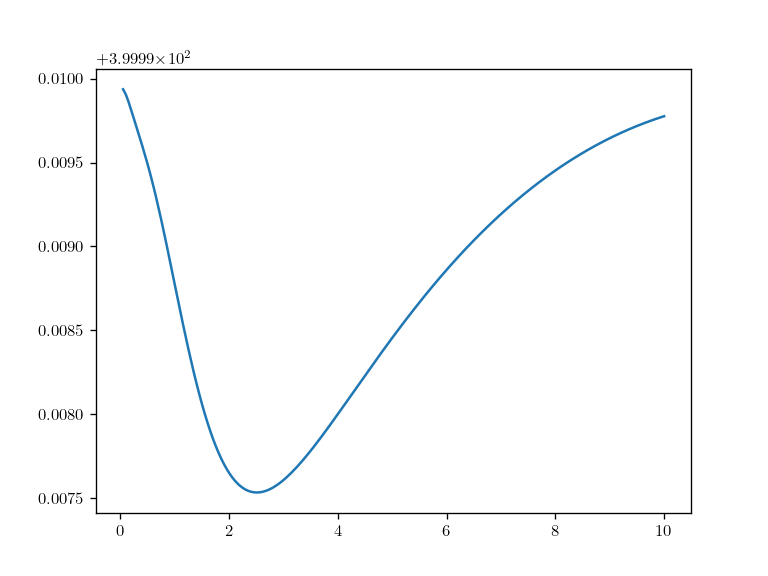

In [61]:
# for i in range(len(radii)):
#     plotEllipsoid(radii[i,:], rotation[i])
#print(d_r)
fig = plt.figure()
plt.plot(t,d_r)
plt.savefig('ds.eps', bbox_inches='tight')

# plt.xlabel('Time')
# plt.show()

In [10]:
def plotEllipsoid(radii, radii2, rotation, ax=None, plotAxes=False, cageColor='b', cageAlpha=0.2):
    """Plot an ellipsoid"""
    make_ax = ax == None
    if make_ax:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    u = np.linspace(0.0, 2.0 * np.pi, 50)
    v = np.linspace(0.0, np.pi, 50)
#     for i in range(len(radii)):
#         cartesian coordinates that correspond to the spherical angles:
    x = np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    
    
    x[x>0] *= radii[0] 
    x[x<0] *= radii2[0]

    # rotate accordingly
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) 
            
            
#     # Plot:
    ax.plot_surface(x, y, z,  rstride=2, cstride=2, color='r')
#     if plotAxes:
#         # make some purdy axes
#         axes = np.array([[radii[0],0.0,0.0],
#                          [0.0,radii[1],0.0],
#                          [0.0,0.0,radii[2]]])
    
#     # rotate accordingly
#         for i in range(len(axes)):
#             axes[i] = np.dot(axes[i], rotation)

#         # plot axes
#         for p in axes:
#             X3 = np.linspace(-p[0], p[0], 100) #+ center[0]
#             Y3 = np.linspace(-p[1], p[1], 100) #+ center[1]
#             Z3 = np.linspace(-p[2], p[2], 100) #+ center[2]
#             ax.plot(X3, Y3, Z3, color=cageColor)

    # plot ellipsoid
    ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color=cageColor, alpha=cageAlpha)
    plt.show()
#     if make_ax:
#         plt.show()
#         plt.close(fig)
#         del fig

## Graphs functions ($\tau$, $q$, ($\xi_{ee},\eta_{ee})$)

In [54]:

def graphs_qs(t_list, q_list):
    fig, ax = plt.subplots()
    plt.plot(t_list, q_list[:, :])
    plt.grid(True)
    ax.set_ylabel(r"$q \ [rad]$", fontsize = 14)
    ax.set_xlim(0, max(t_list))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$q_0$",r"$q_1$",r"$q_2$",r"$q_3$",r"$q_4$",r"$q_5$"),loc="upper right")
    fig.tight_layout()
    plt.show()
    plt.savefig('qs.eps', bbox_inches='tight')


def graphs_taus(t, tau):
    fig, ax = plt.subplots()
    ax = plt.subplot(3, 2, 1)
    plt.plot(t, tau[:, 0])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_0 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 2)
    plt.plot(t, tau[:, 1])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_1 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 3)
    plt.plot(t, tau[:, 2])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_2 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 4)
    plt.plot(t, tau[:, 3])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_3 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 5)
    plt.plot(t, tau[:, 4])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_4 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 2, 6)
    plt.plot(t, tau[:, 5])
    plt.grid(True)
    ax.set_ylabel(r"$\tau_5 \ [-]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    ax.set_xlabel(r'\textbf{Time (s)}')
    # ax.legend((r"$q_0$",r"$q_{0d}$"),loc="upper right")
    fig.tight_layout()
    plt.show()
    plt.savefig('taus.eps', bbox_inches='tight')


def graphs_pose(t, pose, pose_des):
    fig, ax = plt.subplots()
    ax = plt.subplot(3, 1, 1)
    plt.plot(t, pose[:, 0])
    plt.plot(t, pose_des[:, 0],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$x \ [m]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    #ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$x$",r"$x_{d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 1, 2)
    plt.plot(t, pose[:, 1])
    plt.plot(t, pose_des[:, 1],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$y \ [m]$", fontsize = 14)
    ax.set_xlim(0, max(t))
    #ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$y$",r"$y_{d}$"),loc="upper right")
    fig.tight_layout()

    ax = plt.subplot(3, 1, 3)
    plt.plot(t, pose[:, 2])
    plt.plot(t, pose_des[:, 2],linestyle='--')
    plt.grid(True)
    ax.set_ylabel(r"$z \ [m]$", fontsize = 14)
    ax.set_ylim(0, 0.9)
    ax.set_xlim(0, max(t))
    ax.set_xlabel(r'\textbf{Time (s)}')
    ax.legend((r"$z$",r"$z_{d}$"),loc="upper right")
    fig.tight_layout()
    plt.show()
    plt.savefig('pos.eps', bbox_inches='tight')


<IPython.core.display.Javascript object>


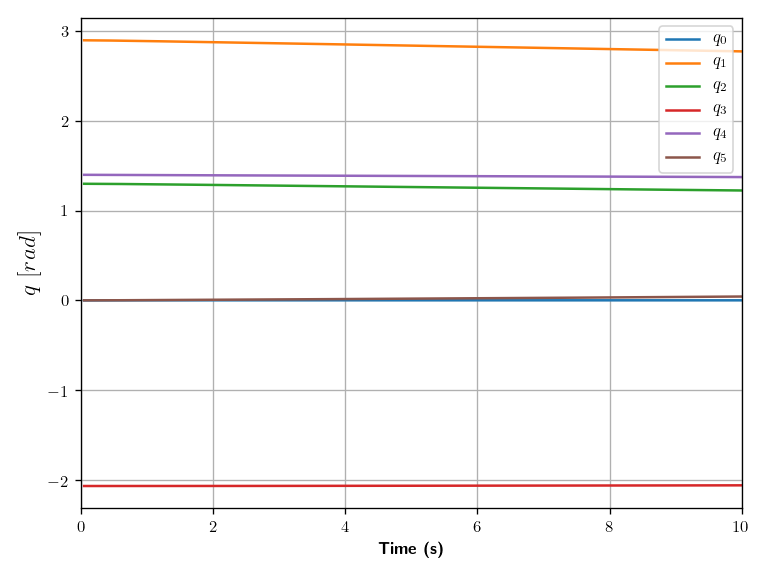

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [62]:
graphs_qs(t, q)

<IPython.core.display.Javascript object>


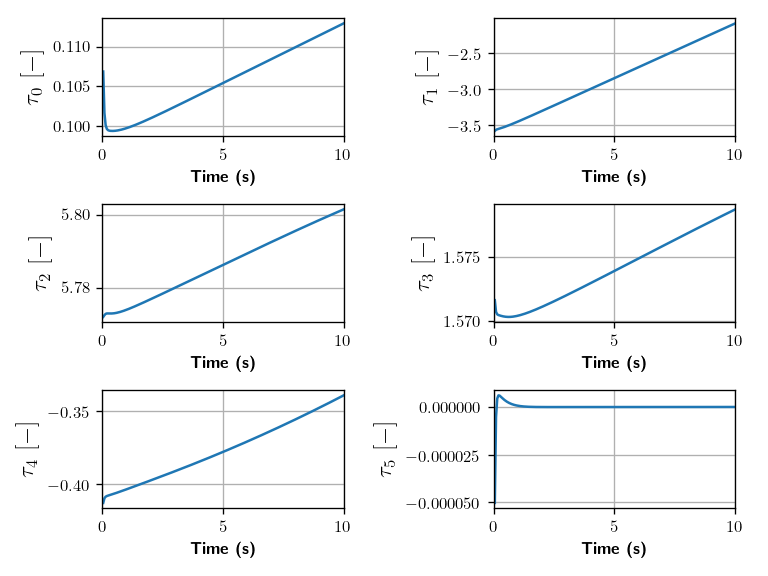

In [63]:
graphs_taus(t, tau)

<IPython.core.display.Javascript object>


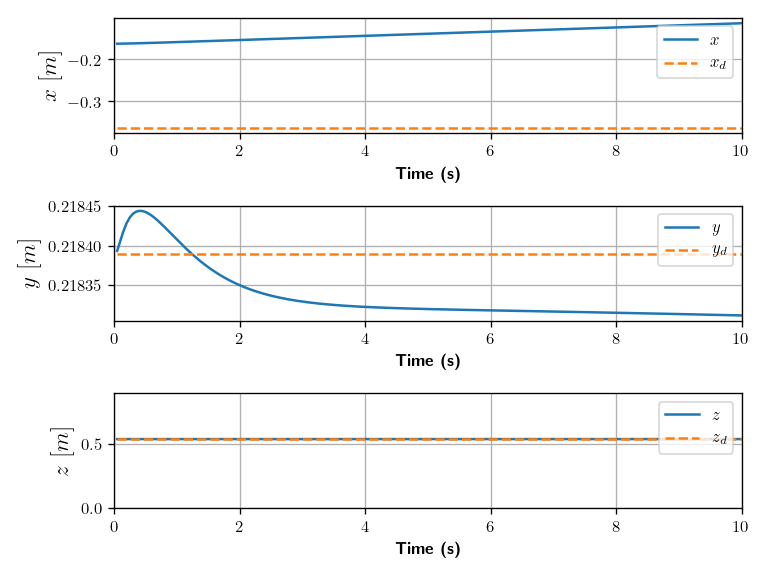

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

In [64]:
graphs_pose(t, pose, pose_des)

In [39]:
# Sample a random configuration
q =np.array([0, 2.9, 1.3, -2.07, 1.4,0]) # Natural position as in the real case
qdot = pin.utils.zero(model.nv) # this is the angular velocity
a = pin.utils.zero(model.nv) # angular acceleration

pin.forwardKinematics(model,data,q)
pin.updateFramePlacements(model,data)
OM_act = data.oMf[frameIndex] # This is the pose of the end-effector refered in the frame of the base
oMdes = pin.SE3(OM_act.rotation,np.array([-0.3643, 0.21839, 0.5414]))# This is the pose of the end-effector refered in the frame of the base

fx = -2; fy=0; fz=0; nx =0; ny=0; nz=0

# Construction of goal driven
    # for goal dirven
d_min = 15
d_barra =70
d_max =200    

## First half-ellipsoid
### eigenvectors
z_unit = np.array([0,0,1])
v1 = (oMdes.translation - OM_act.translation)/norm(oMdes.translation - OM_act.translation)
v2 = np.cross(z_unit,v1)/norm(np.cross(z_unit,v1))
v3 = np.cross(v1,v2)
Q = np.concatenate((v1[:,None],v2[:,None],v3[:,None]),axis=1)
### eigenvalues
lamda1 = 1/d_min**2
lamda2 = 1/d_barra**2
lamda3 = 1/d_barra**2
lambda_d = np.diag(np.array([lamda1,lamda2,lamda3])) # Mass Matrix
A_dr1 = (Q@lambda_d@Q.T) # Matrix representing the first half-ellipsoid matrix
## Second half-ellipsoid. Here the only thing that changes is the length of the first semi-axis
### eigenvalues
lamda11 = 1/d_max**2
lambda_d2 = np.diag(np.array([lamda11,lamda2,lamda3])) # Mass Matrix
A_dr2 = (Q@lambda_d2@Q.T) # Matrix representing the second half-ellipsoid matrix

ftrans = np.array([fx,fy,fz]) # linear force
ver_sign = np.sign(ftrans*v1) # the sign is gonna be positive if it is going to the same direction as the goal, # negative otherwise
u_f = ftrans/norm(ftrans) # direction of the force
# d_r = 1/np.sqrt(u_f.T@A_dr@u_f) # value of the variable damping        

radii = 1.0 / np.sqrt(np.diag(A_dr1))
radii2 = 1.0 / np.sqrt(np.diag(A_dr2))

# print(ver_sign)        

# if ((ver_sign[0] > 0) or (ver_sign[1] > 0) or (ver_sign[2] > 0) ):
#     d_r = 1/np.sqrt(u_f.T@A_dr1@u_f) # value of the variable damping        
# else:
#     d_r = 1/np.sqrt(u_f.T@A_dr2@u_f) # value of the variable damping    


# print(d_r)
    


<IPython.core.display.Javascript object>


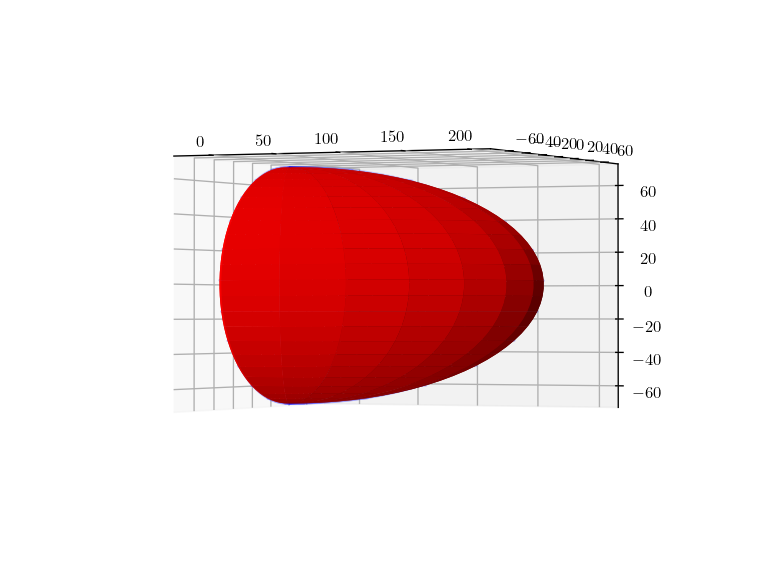

In [40]:
plotEllipsoid(radii, radii2, Q)

<IPython.core.display.Javascript object>


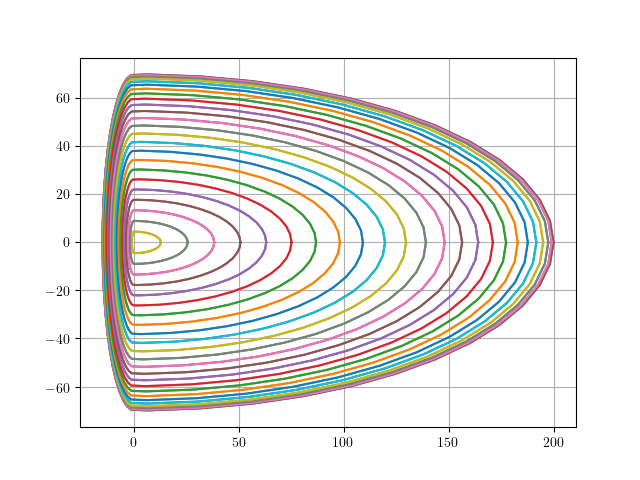

In [18]:
u = np.linspace(0.0, 2.0 * np.pi, 50)
v = np.linspace(0.0, np.pi, 50)


xt = np.outer(np.cos(u), np.sin(v))
y = radii[1] * np.outer(np.sin(u), np.sin(v))

xt[xt<0] *= radii[0] 
xt[xt>=0] *= radii2[0]

plt.figure()
plt.plot(xt,y)
plt.grid()

<IPython.core.display.Javascript object>


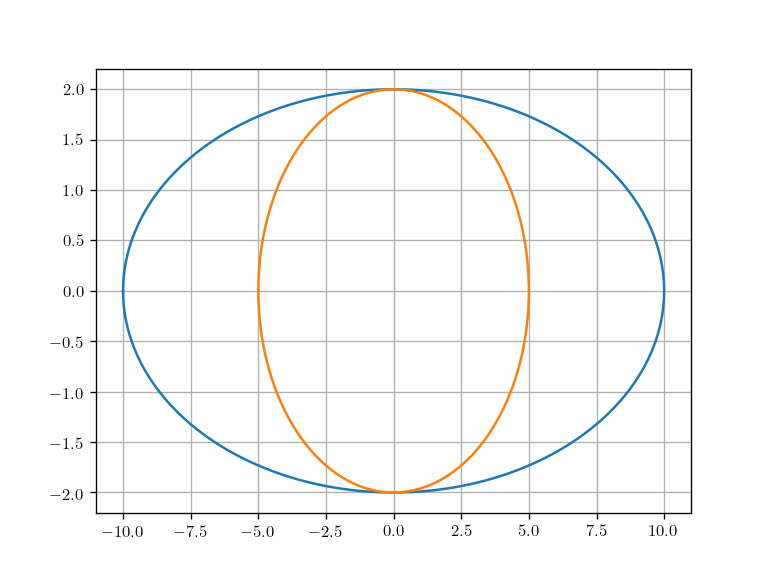

<IPython.core.display.Javascript object>


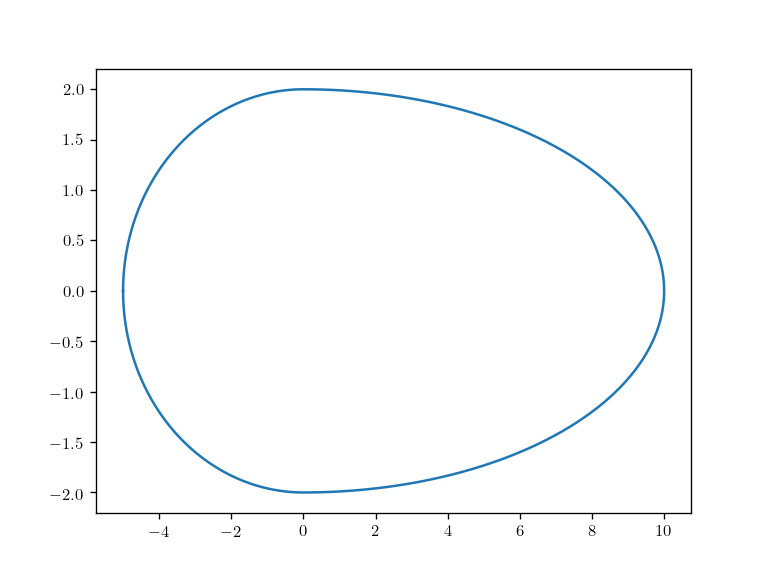

In [6]:
# This helped me to graph the combination of two ellipses
S = np.diag([10,2])
x = np.linspace(-np.pi, np.pi, 1001)
th = np.linspace(-np.pi, np.pi, 1001)
x = np.exp(1j*th)
fig = plt.figure()
plt.plot(x.real*S[0,0], x.imag*S[1,1])
plt.grid()
plt.plot(x.real*S[0,0]/2,x.imag*S[1,1])
xe = x.real*S[0,0]
xe[xe<=0.] = x[xe<=0.].real*S[0,0]/2
plt.figure()
plt.plot(xe,x.imag*S[1,1])
plt.savefig('test.eps', bbox_inches='tight')
#plt.grid()